# Pull-Up Performance EDA and Model
In this notebook, I will explore the relationships of different player stats and their future pull-up rate.  

Goals:
- Look for what stats might best predict pull-up rate.
- Find the best model to make accurate predictions.

Conclusions: 
- Past catch-and-shoot and pull-up expected value (shooting ability) are very important.
- Past catch-and-shoot and pull-up rate (shooting rate) are also important.

## 0. Importing Libraries and Data

In [5]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [6]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [7]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['PULL_UP_FGA'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [8]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['PULL_UP_EV'])

In [9]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_PULL_UP_EV']]
X = data.drop(columns='TARGET_PULL_UP_EV')

#### Splitting X and y into train, validate, and test sets

In [10]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'PULL_UP_EV')

## 2. Determine Potential Features
- Strong shooting skills (catch-and-shoot, open shooting) are related of better pull-up shooting.

#### Finding correlated features

In [11]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [12]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [13]:
# Looking at the most correlated features with the target
corr_features

['PULL_UP_FG3M_WEIGHTED',
 'PULL_UP_EFG_PCT_WEIGHTED',
 'PULL_UP_EV_WEIGHTED',
 'PULL_UP_FG3M',
 'PULL_UP_FG3A_WEIGHTED',
 'PULL_UP_FG3M_PER_MIN_WEIGHTED',
 '3_6_DRIBBLES_FG3A',
 'PULL_UP_FG3A',
 'PULL_UP_FG3M_PER_MIN',
 'PULL_UP_EV']

In [14]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_PULL_UP_EV'], alpha=.3)

#### Graphing correlated features

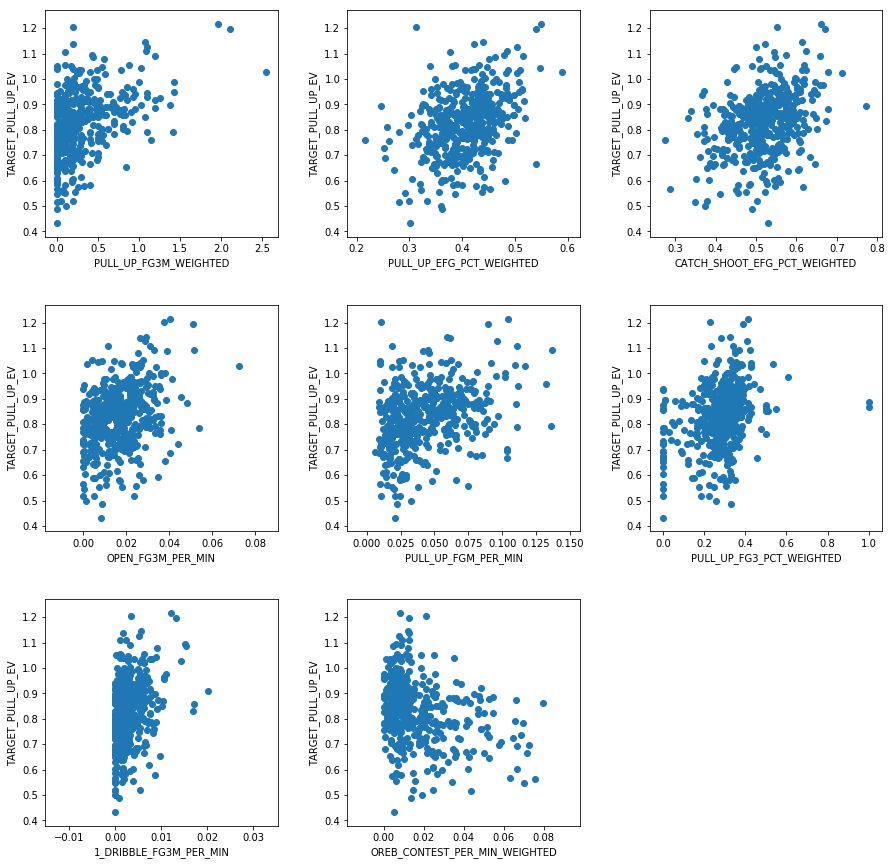

In [15]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

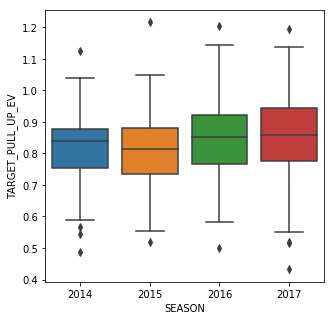

In [16]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

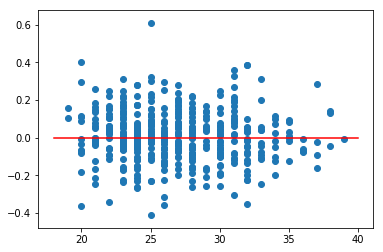

In [17]:
plt.scatter(X_train['AGE'], y_train['TARGET_PULL_UP_EV'] - X_train['PULL_UP_EV'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used a lot of features.
- Score was low although this is an EV category.

In [18]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

5

In [19]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['DIST_MILES_DEF_PER_MIN', '3_6_DRIBBLES_FGA_PER_MIN',
       '3_6_DRIBBLES_FG2A_PER_MIN', '3_6_DRIBBLES_FG3A_PER_MIN',
       'DIST_MILES_DEF_PER_MIN_WEIGHTED'],
      dtype='object')

In [20]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.11351685082655805

#### K BEST
- Scores went down and then up as more features were added.
- Making and taking pull-up shots is very important.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

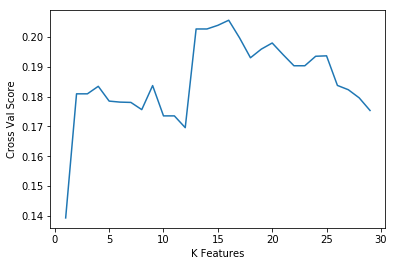

In [21]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 30):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 30), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

1  Feature Cross Val Scores:  [0.10518207 0.03968665 0.18505722 0.19672953 0.17009283]
2  Feature Cross Val Scores:  [0.16058839 0.06521041 0.19433297 0.28884521 0.19560355]
3  Feature Cross Val Scores:  [0.16058839 0.06521041 0.19433297 0.28884521 0.19560355]
4  Feature Cross Val Scores:  [0.14855322 0.07723449 0.18647025 0.30676445 0.19814807]
5  Feature Cross Val Scores:  [0.147892   0.07881523 0.15950976 0.30423316 0.20194562]
6  Feature Cross Val Scores:  [0.14479075 0.07978725 0.16425108 0.30821376 0.19365859]
7  Feature Cross Val Scores:  [0.1372683  0.08220865 0.16570649 0.31002368 0.19499181]
8  Feature Cross Val Scores:  [0.13411033 0.07764297 0.16569498 0.31003236 0.19064058]
9  Feature Cross Val Scores:  [0.11464116 0.10331699 0.1727829  0.33663661 0.19100715]
10  Feature Cross Val Scores:  [0.11267384 0.09827048 0.13941669 0.33300445 0.18427785]
11  Feature Cross Val Scores:  [0.11267384 0.09827048 0.13941669 0.33300445 0.18427785]


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

12  Feature Cross Val Scores:  [0.11276978 0.09791975 0.13919936 0.32747403 0.17054941]
13  Feature Cross Val Scores:  [0.18579531 0.13099807 0.09999252 0.38455176 0.21186641]
14  Feature Cross Val Scores:  [0.18579531 0.13099807 0.09999252 0.38455176 0.21186641]
15  Feature Cross Val Scores:  [0.18949566 0.14171974 0.12531359 0.35851398 0.20426125]
16  Feature Cross Val Scores:  [0.19294601 0.14384544 0.12881803 0.35192829 0.21028805]
17  Feature Cross Val Scores:  [0.19121308 0.14631549 0.12957632 0.33331043 0.19778543]
18  Feature Cross Val Scores:  [0.18849033 0.1407091  0.10318356 0.33377326 0.19881871]
19  Feature Cross Val Scores:  [0.20158395 0.14443843 0.0968764  0.3435176  0.19305424]
20  Feature Cross Val Scores:  [0.2128501  0.14369863 0.0823323  0.35304359 0.19778315]


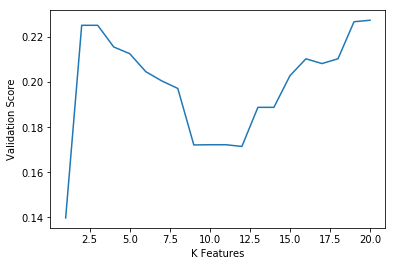

In [22]:
# Checking out 1 - 20 features
k_scores = []
for k in range(1, 21):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 21), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [23]:
# Printing out the scores with 16 features
k_best = SelectKBest(f_regression, k=16)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.21036720677027487

In [24]:
# Printing the model features
model_features

['PULL_UP_FG3M',
 'PULL_UP_FG3A',
 'PULL_UP_EFG_PCT',
 '3_6_DRIBBLES_FG3M',
 '3_6_DRIBBLES_FG3A',
 'PULL_UP_EV',
 'PULL_UP_FG3M_PER_MIN',
 'CATCH_SHOOT_EFG_PCT_WEIGHTED',
 'PULL_UP_FG3M_WEIGHTED',
 'PULL_UP_FG3A_WEIGHTED',
 'PULL_UP_EFG_PCT_WEIGHTED',
 'CATCH_SHOOT_EV_WEIGHTED',
 'PULL_UP_EV_WEIGHTED',
 'PULL_UP_PTS_PER_MIN_WEIGHTED',
 'PULL_UP_FG3M_PER_MIN_WEIGHTED',
 'PULL_UP_FG3A_PER_MIN_WEIGHTED']

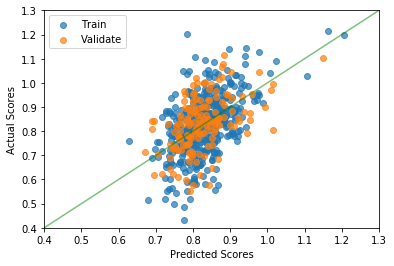

In [25]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=1.3,
              axis_min=.4)

#### PCA
- The elbow method again seems to not help as much as keeping more components
- With 3 components the model did similarly to others

In [26]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.30187874, 0.17455274, 0.08396675, 0.04364809, 0.03122627,
       0.02581948, 0.0220262 , 0.0189501 , 0.01685003, 0.01551235,
       0.01385355, 0.01257991, 0.01062274, 0.00986834, 0.00955056])

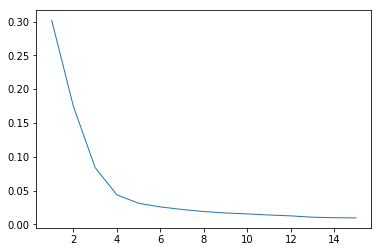

In [27]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [28]:
# Looking at the cross val score
pca = PCA(n_components=3)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.19893249, 0.13024999, 0.09712388, 0.24030181, 0.19555071])

In [29]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.17455148459955594

#### Neural Net
- Graph has a strange pattern. Lower predicted scores have a huge actual variance.
- Performed really poorly.

In [30]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [31]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [32]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [33]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

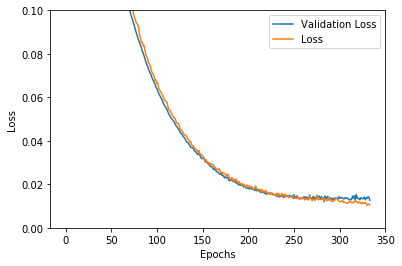

In [34]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [35]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.03707809405684592

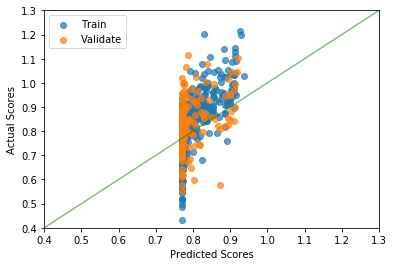

In [36]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=1.3, axis_min=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the 1 feature model.

In [37]:
# Saving the model features
model_features = ['PULL_UP_FG_PCT_WEIGHTED', 'PULL_UP_FG3_PCT_WEIGHTED', 'PULL_UP_FG3A_WEIGHTED',
                  'PULL_UP_FGA_WEIGHTED', 'CATCH_SHOOT_EV', 'CATCH_SHOOT_RATE_WEIGHTED', 'DRIVE_RATE_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015',
                  '2016', '2017']

In [38]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.23094122, 0.1076272 , 0.0990953 , 0.32891536, 0.21847941])

In [39]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.180209528477993

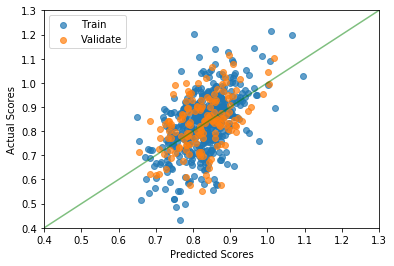

In [40]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=1.3,
              axis_min=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are slightly improved compared to the linear regression.
- Pull-up stats and catch-and-shoot EV were all pretty important.

In [41]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [42]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.25793535, 0.15784768, 0.10549563, 0.3322134 , 0.20679557])

In [43]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.1833275071716136

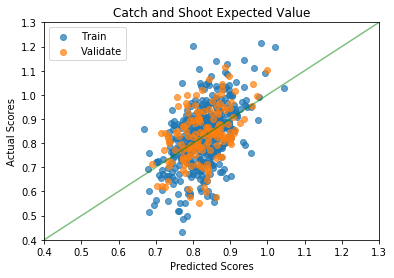

In [44]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=1.3, axis_min=.4)
plt.title('Catch and Shoot Expected Value');

In [45]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.20409989, 0.13332594, 0.10117058, 0.26904201, 0.206504  ])

In [46]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.1984378518425448

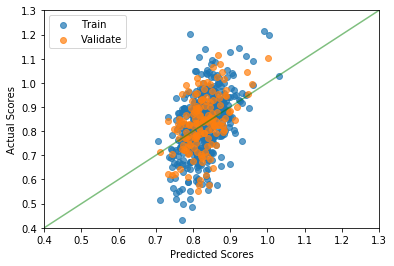

In [47]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=1.3, axis_min=.4)

In [48]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
PULL_UP_FG_PCT_WEIGHTED,0.013023,0.015770
PULL_UP_FG3_PCT_WEIGHTED,0.009636,0.010973
PULL_UP_FG3A_WEIGHTED,0.023726,0.016481
PULL_UP_FGA_WEIGHTED,0.000000,0.005520
CATCH_SHOOT_EV,0.016523,0.014913
CATCH_SHOOT_RATE_WEIGHTED,0.000000,0.008521
DRIVE_RATE_WEIGHTED,0.000000,0.001693
POST_TOUCH_RATE_WEIGHTED,-0.001741,-0.007268
PULL_UP_RATE_WEIGHTED,0.000000,0.003804
PLAYER_HEIGHT_INCHES,-0.002831,-0.008150


#### Final scores (Ridge)
- The r2 score on the test set was pretty decent given the variation in the cross validation scores.
- There was a 29.1 percent improvement in the rmse compared to the baseline using the test set.

In [49]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.22273731836661637

In [50]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.11018012120564503

In [51]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['PULL_UP_EV']) ** .5
baseline

0.15534844406316944

In [52]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.29075490990535824

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [53]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_PULL_UP_EV'] = ridge.predict(X_train_scaled)

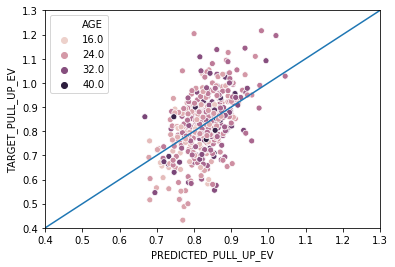

In [54]:
sns.scatterplot('PREDICTED_PULL_UP_EV', 'TARGET_PULL_UP_EV', data=train, hue='AGE')
plt.plot([0,1.3], [0,1.3])
plt.xlim(.4, 1.3)
plt.ylim(.4, 1.3);

#### Saving the predictions

In [55]:
# Loading the target dataframe
target_df = pd.read_csv('./data/target_df', index_col=0)

In [56]:
# Adding the predictions to the target dataframe
master_scaled = scaler.transform(master_df[model_features].dropna())
predictions = ridge.predict(master_scaled)
predictions_index = master_df[model_features].dropna().index
predictions_df = pd.DataFrame(predictions, columns=['PRED_PULL_UP_EV'], index=predictions_index)
target_df = pd.merge(target_df, predictions_df, how='left', left_index=True, right_index=True)

In [57]:
# Saving the dataframe
target_df.to_csv('./data/target_df')